In [1]:
import sys
import platform
from os.path import join, exists, abspath
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import util, deal_spm
import SSS.plot as splt

---

In [9]:
dir_atlas = util.get_dir_atlas()
Hem = ['L','R']
print(exists(dir_atlas), dir_atlas)

True /home/sungbeenpark/github/SeqSpatialSupp_fMRI/atlas/fs_LR_32k


In [10]:
underlay = join(dir_atlas,'fs_LR.32k.LR.sulc.dscalar.gii')
border = join(dir_git,'surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border')

In [11]:
# roi = nb.load(join(dir_atlas,'ROI.L.SSS.label.gii'))
# list_roi = ['SMA', 'PMv', 'PMd', 'M1', 'S1', 'SPLa', 'SPLp', 'DSVC', 'MT+', 'VSVC', 'EAC']

roi = nb.load(join(dir_atlas,'ROI.32k.L.label.gii'))
list_roi = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

data_roi = roi.darrays[0].data

# roi = nib.load(join(dir_atlas,'ROI.32k.L.label.gii'))
# list_roi = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
# data_roi = roi.darrays[0].data

print(np.unique(data_roi), data_roi.shape)

[0 1 2 3 4 5 6 7 8] (32492,)


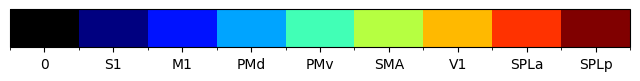

In [12]:
# cmap = gifti_to_cmap(data)
cmap = splt.cmap_to_cbar(list_roi, cmap='jet')

<Axes: >

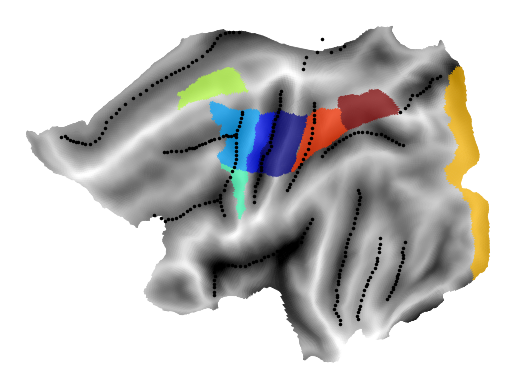

In [13]:
fig, ax = plt.subplots()

plt.sca(ax)
surf.plot.plotmap(
    data=data_roi,
    surf='fs32k_L',
    underlay=underlay, alpha=0.7, cmap=cmap, colorbar=False,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)

---

### Indivisual surface info

In [14]:
glm = 'glm_3'
subj = 'S01'

In [17]:
white, pial, mask = splt.get_WPM(subj, glm)
print(white)
print(pial)
print(mask)

/mnt/f/SeqSpatialSupp_fMRI/surfaceWB/S01/S01.L.white.32k.surf.gii
/mnt/f/SeqSpatialSupp_fMRI/surfaceWB/S01/S01.L.pial.32k.surf.gii
/mnt/f/SeqSpatialSupp_fMRI/glm_3/S01/mask.nii


### Get vertecies from Atlas

In [18]:
# dir_atlas = join(dir_git,'SeqSpatialSupp_fMRI/atlas/fs_LR_32k')
def get_atlas(dir_atlas, roi, list_roi=['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp'], atlas='fs32k_L', mask='ROI.32k.L.label.gii'):
    np.where(np.array(list_roi) == roi)[0][0]
    label = idx + 1

    ## Get the atlas
    atlas_left, ainfo = am.get_atlas(atlas)
    
    ## Set the Gifti file for the region (func.gii or label.gii)
    ## This one uses any value >0 as part of the ROI
    subatlas = atlas_left.get_subatlas_image(
        mask_img=join(dir_atlas,mask),
        value=label
    )
    vertex = subatlas.vertex[0]

    return vertex

### Data Extraction using atlas maps

One the Atlas map is built (surface of volume-based), you can use it to extract data from the native space of the subject.

In [32]:
def extract_beta(dir_root, dir_atlas, glm, subj, roi):
    white, pial, mask = get_fname_wpm(dir_root=dir_root, subj=subj, glm=glm)
    vertex = get_atlas(dir_atlas=dir_atlas, roi=roi)

    ## Define atlas map
    amap = am.AtlasMapSurf(vertex, white, pial, mask)
    
    ## Compute the voxels in native space
    amap.build()
    
    ## save the ROI mask in native space for checking only
    # amap.save_as_image('/sub-01/ROI_mask.nii')

    dir_glm = join(dir_root,glm)
    ## This extract all the relevant voxels in native space (use for RSA). Map beta.nii:
    beta = amap.extract_data_native(
        sorted(glob(join(dir_glm,subj,'beta_*.nii')))[:-8]
    )

    ## map ResMS.nii
    ResMS = amap.extract_data_native([join(dir_glm,subj,'ResMS.nii')])

    ## this statement maps the data to group space
    # data = amap.extract_data_native(fnames)
    # data_g = amap.map_native_to_group(data)
    # data_g = amap.extract_data_group(fnames)
    
    return beta, ResMS

In [20]:
# param = '[6 16]'

# ## Load beta (Cifti)
# cii = nb.load(join(dir_glm,subj,'hrf_tune/cifti.L.%s.%s.%s.%s.beta.dscalar.nii'%(glm,param,subj,roi)))
# cii.shape

# fig, ax = plt.subplots()

# ## (# interest, # voxels)
# sns.heatmap(cii.get_fdata(),ax=ax)
# plt.show()

In [21]:
def load_glm_info(vec_mat):
    file = h5py.File(vec_mat)
    vec = file['vectors']

    # vec : (# interest, 3) cell type variable
    rows, cols = vec.shape
    
    # column head
    col = 0
    tmp = []
    for row in np.arange(rows):
        ref = vec[row,col]
        tmp.append(''.join(map(chr, file[ref][:].reshape(-1))))
    column_head = np.copy(tmp)
    
    # partition vector
    col = 1
    tmp = []
    for row in np.arange(rows):
        ref = vec[row,col]
        tmp = np.concatenate([tmp, file[ref][:].reshape(-1)]).astype(int)
    part_vec = tmp.copy()
    
    # condition vector
    col = 2
    tmp = []
    for row in np.arange(rows):
        ref = vec[row,col]
        tmp = np.concatenate([tmp, file[ref][:].reshape(-1)]).astype(int)
    cond_vec = tmp.copy()
    
    return column_head, part_vec, cond_vec

---

## Pre-whitening

OLS: $\underset{K \times P}{\hat{\beta}} = \underset{K \times T}{X}^{+}\underset{T \times P}{Y} = (\underset{K \times T}{X}^{T}\underset{T \times K}{X})^{-1}\underset{K \times T}{X}^{T}\underset{T \times P}{Y}$

$\rightarrow$ (spatial) variance-covariance matrix: $\underset{P \times P}{\Sigma} = \frac{1}{T}\underset{P \times T}{\epsilon}^{T}\underset{T \times P}{\epsilon}$

where $\epsilon = Y - X\hat{\beta}$

### (spatial) Pre-whitening

$$
\tilde{\beta} = \underset{K \times P}{\beta}\underset{P \times P}{\Sigma}^{-\frac{1}{2}}
$$

- Multi-variate pre-whitening:
  $\Sigma_{ij}^{-\frac{1}{2}}=Cov(\epsilon_{i},\epsilon_{j})=\frac{1}{T}\underset{1 \times T}{\epsilon_{i}}^{T}\underset{T \times 1}{\epsilon_{j}}$

- Uni-variate pre-whitening:
  $\Sigma_{ij}^{-\frac{1}{2}}=Cov(\epsilon_{i},\epsilon_{j})=\frac{1}{T}\underset{1 \times T}{\epsilon_{i}}^{T}\underset{T \times 1}{\epsilon_{j}}\textcolor{red}{\delta_{ij}}$
  $$
  \Sigma^{-\frac{1}{2}} = \begin{bmatrix}
\frac{1}{\sigma_{1}} & \textcolor{gray}{0} & \cdots & \textcolor{gray}{0} \\
\textcolor{gray}{0} & \frac{1}{\sigma_{2}} & \cdots & \textcolor{gray}{0} \\
\vdots & \vdots & \ddots & \vdots \\
\textcolor{gray}{0} & \cdots & \textcolor{gray}{0} & \frac{1}{\sigma_{P}} \\
\end{bmatrix}
  $$ = (`ResMS.nii`)$^{-\frac{1}{2}}$

In [43]:
def prewhited_beta(dir_root, dir_atlas, glm, subj, roi):
    beta, ResMS = extract_beta(dir_root=dir_root, dir_atlas=dir_atlas, glm=glm, subj=subj, roi=roi)
    
    column_head, part_vec, cond_vec = load_glm_info(vec_mat=join(dir_root,glm,subj,'hrf_tune/vec_[6 16].mat'))

    ## Interest regressors
    iC = cond_vec>0
    # print(iC)
    column_head = column_head[iC]
    part_vec = part_vec[iC]
    cond_vec = cond_vec[iC]
    
    beta = beta[iC,:]
    # print(beta.shape)

    ## prewhitening
    beta_whiten = beta/np.sqrt(ResMS)
    # print(np.isnan(beta_whiten).sum(), beta_whiten.shape)
    beta_whiten = beta_whiten[:,~np.isnan(beta_whiten).any(axis=0)]
    # print(np.isnan(beta_whiten).sum(), beta_whiten.shape)

    return beta_whiten, column_head, part_vec, cond_vec

In [34]:
subj = 'R01'
glm = 'glm_3'
roi = 'M1'

In [35]:
beta, ResMS = extract_beta(dir_root=dir_root, dir_atlas=dir_atlas, glm=glm, subj=subj, roi=roi)
print(beta.shape, ResMS.shape)

(72, 551) (1, 551)


In [38]:
beta_whiten, column_head, part_vec, cond_vec = prewhited_beta(dir_root=dir_root, dir_atlas=dir_atlas, glm=glm, subj=subj, roi=roi)
print(beta_whiten.shape)

(64, 542)


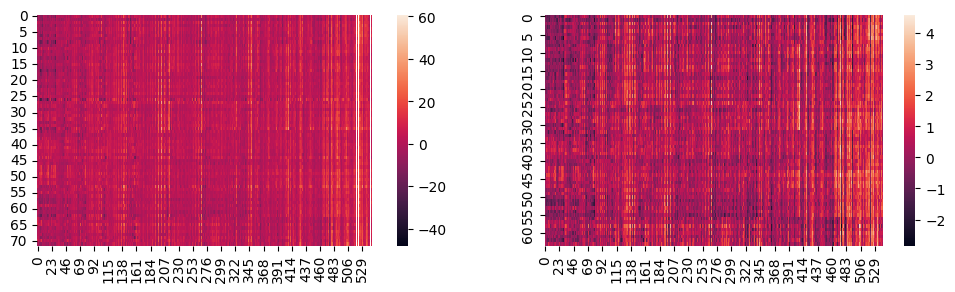

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(12,3))

## beta.shape = (# interest, # voxels)
sns.heatmap(beta, ax=axs[0])
sns.heatmap(beta_whiten, ax=axs[1])
plt.show()

---

## Reliability Estimation

As a measure of functional signal-to-noise ratio, we can calculate the reliability of activity patterns across runs. The measured activity pattern from subject $i$ in run $j$ ($y_{i,j}$) can be thought of consisting of the signal in subject $i$ ($s_i$) and measurement noise $\epsilon_{i,j}$.
$$
y_{i,j}=s_{i}+\epsilon_{i,j}
$$

For each subject, we can calculate the variances (or second moments) of these patterns across voxels and / or conditions:
$$
v_{s}=s_{i}^{T}s_{i}
$$
$$
v_{\epsilon}=E(\epsilon^{T}\epsilon)
$$

The correlation of the measured activity patterns across runs then is:
$$
r_{run}=\frac{v_{s}}{v_{s}+v_{\epsilon}}
$$

This reliability measure is the reliability of one measurement (run). The (theoretical) reliability of the mean activity pattern (across $N$ measurement runs) then would be:
$$
r_{whole}=\frac{v_{s}}{v_{s}+v_{\epsilon}/N}
$$

With a bit of algebra, you can calculate the theoretical reliability of the mean activity pattern from the reliability across runs:
$$
r_{whole}=\frac{r_{run}N}{r_{run}(N-1)+1}
$$

This is the *Spearman-brown prediction formula*

In [44]:
print(len(column_head), column_head)
print(len(part_vec), part_vec)
print(len(cond_vec), cond_vec)

64 ['Trial-State 1' 'Trial-State 2' 'Trial-State 3' 'Trial-State 4'
 'Trial-State 5' 'Trial-State 6' 'Trial-State 7' 'Trial-State 8'
 'Trial-State 1' 'Trial-State 2' 'Trial-State 3' 'Trial-State 4'
 'Trial-State 5' 'Trial-State 6' 'Trial-State 7' 'Trial-State 8'
 'Trial-State 1' 'Trial-State 2' 'Trial-State 3' 'Trial-State 4'
 'Trial-State 5' 'Trial-State 6' 'Trial-State 7' 'Trial-State 8'
 'Trial-State 1' 'Trial-State 2' 'Trial-State 3' 'Trial-State 4'
 'Trial-State 5' 'Trial-State 6' 'Trial-State 7' 'Trial-State 8'
 'Trial-State 1' 'Trial-State 2' 'Trial-State 3' 'Trial-State 4'
 'Trial-State 5' 'Trial-State 6' 'Trial-State 7' 'Trial-State 8'
 'Trial-State 1' 'Trial-State 2' 'Trial-State 3' 'Trial-State 4'
 'Trial-State 5' 'Trial-State 6' 'Trial-State 7' 'Trial-State 8'
 'Trial-State 1' 'Trial-State 2' 'Trial-State 3' 'Trial-State 4'
 'Trial-State 5' 'Trial-State 6' 'Trial-State 7' 'Trial-State 8'
 'Trial-State 1' 'Trial-State 2' 'Trial-State 3' 'Trial-State 4'
 'Trial-State 5' 'Tria

In [40]:
## We can quickly calculate the reltiability of the data within each subjects across different runs:
rw = rel.within_subj(
    data=beta_whiten,
    cond_vec=cond_vec, part_vec=part_vec,
    separate='none', subtract_mean=True
)

## rw will be a vector of reliability values for each subject, if multiple subjects are present.
print(rw)

[0.13847874]


In [30]:
list_cond = [
    'Trial-State 1', 'Trial-State 2', 'Trial-State 3', 'Trial-State 4',
    'Trial-State 5', 'Trial-State 6', 'Trial-State 7', 'Trial-State 8'
]

for cond in list_cond:
    idx = np.where(cond==column_head)[0]
    print(cond, idx)

Trial-State 1 [ 0  9 18 27 36 45 54 63]
Trial-State 2 [ 1 10 19 28 37 46 55 64]
Trial-State 3 [ 2 11 20 29 38 47 56 65]
Trial-State 4 [ 3 12 21 30 39 48 57 66]
Trial-State 5 [ 4 13 22 31 40 49 58 67]
Trial-State 6 [ 5 14 23 32 41 50 59 68]
Trial-State 7 [ 6 15 24 33 42 51 60 69]
Trial-State 8 [ 7 16 25 34 43 52 61 70]


In [30]:
df = {
    'sn':[],
    'hem':[],
    'region':[],
    'cond':[],
    'r':[]
}
for cond in list_cond:
    idx = np.where(cond==column_head)[0]

    print(cond)
    print(beta_whiten[idx,:].shape)
    print(cond_vec[idx])
    print(part_vec[idx])
    
    df['sn'].append(subj)
    df['hem'].append('L')
    df['cond'].append(cond)
    df['region'].append(roi)
    df['r'].append(
        rel.within_subj(
            data=beta_whiten[idx,:],
            cond_vec=cond_vec[idx], part_vec=part_vec[idx],
            separate='none', subtract_mean=True
        )
    )

df = pd.DataFrame(df)
df

Trial-State 1
(8, 612)
[1 1 1 1 1 1 1 1]
[1 2 3 4 5 6 7 8]
Trial-State 2
(8, 612)
[2 2 2 2 2 2 2 2]
[1 2 3 4 5 6 7 8]
Trial-State 3
(8, 612)
[3 3 3 3 3 3 3 3]
[1 2 3 4 5 6 7 8]
Trial-State 4
(8, 612)
[4 4 4 4 4 4 4 4]
[1 2 3 4 5 6 7 8]
Trial-State 5
(8, 612)
[5 5 5 5 5 5 5 5]
[1 2 3 4 5 6 7 8]
Trial-State 6
(8, 612)
[6 6 6 6 6 6 6 6]
[1 2 3 4 5 6 7 8]
Trial-State 7
(8, 612)
[7 7 7 7 7 7 7 7]
[1 2 3 4 5 6 7 8]
Trial-State 8
(8, 612)
[8 8 8 8 8 8 8 8]
[1 2 3 4 5 6 7 8]


/Users/sungbeenpark/github/Functional_Fusion/Functional_Fusion/reliability.py:78: RuntimeWarning: invalid value encountered in divide
  v_e = (SS_1 - SS_2) / n_df
/Users/sungbeenpark/github/Functional_Fusion/Functional_Fusion/reliability.py:79: RuntimeWarning: invalid value encountered in divide
  v_s = (SS_2) / n_df


,sn,hem,region,cond,r
0,R01,L,M1,Trial-State 1,[nan]
1,R01,L,M1,Trial-State 2,[nan]
2,R01,L,M1,Trial-State 3,[nan]
3,R01,L,M1,Trial-State 4,[nan]
4,R01,L,M1,Trial-State 5,[nan]
5,R01,L,M1,Trial-State 6,[nan]
6,R01,L,M1,Trial-State 7,[nan]
7,R01,L,M1,Trial-State 8,[nan]


---

In [50]:
fname = join(dir_git,'SeqSpatialSupp_fMRI/getcanonicalhrflibrary.tsv')
exists(fname)

True

In [70]:
dg.idxmax(axis=0)

0       26
0.1     27
0.2     29
0.3     29
0.4     30
0.5     32
0.6     33
0.7     35
0.8     38
0.9     40
0.10    42
0.11    44
0.12    46
0.13    48
0.14    50
0.15    52
0.16    53
0.17    55
0.18    55
0.19    56
dtype: int64

<Axes: >

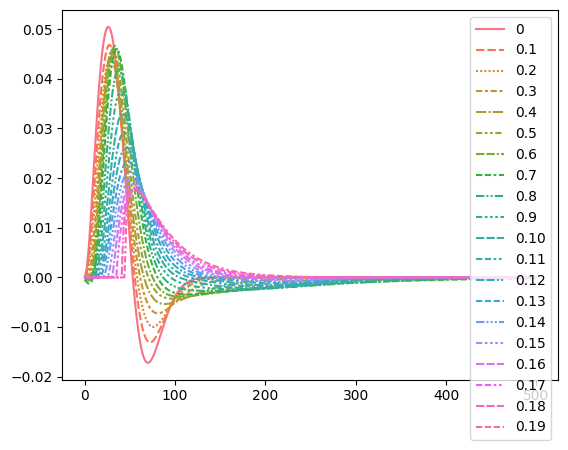

In [71]:
dg = pd.read_csv(fname, sep='\t')
sns.lineplot(dg)

In [32]:
# %whos